In [0]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jan 30 20:19:56 2019

@author: arpit
"""
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tensorflow.examples.tutorials.mnist import input_data

#os.chdir('D:\IUB\Deep Learning\Assignments\Assignment-1\data')

In [0]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

In [0]:
#Defining model specifications
learning_rate = 0.0003
act_layers = [tf.nn.relu, tf.nn.relu, tf.nn.relu, tf.nn.relu, tf.nn.softmax]
neurons = [1024, 1024, 1024, 1024, 10]
num_layers = len(act_layers)
batch_size = 1000
total_train_images = np.shape(mnist.train.images)[0]

In [0]:
#Generating a deep network of n layers with specific activation functions
#and specified number of neurons in each layer
def getModel(x , act_layers , neurons):
    num_layers = len(act_layers)
    layers = [0]*num_layers
    
    for i in range(0 , len(act_layers)):        
        if i == 0:
            layers[i] = tf.layers.dense(x , units= neurons[i] , activation=act_layers[i])        
        elif i < num_layers-1:
            layers[i] = tf.layers.dense(layers[i-1] , units= neurons[i] , activation=act_layers[i])
        else:
            layers[i] = tf.layers.dense(layers[i-1] , units= neurons[i] , activation=act_layers[i])
    
    return layers

In [0]:
#Creating placeholders for input and output
input = tf.placeholder(tf.float32, [None, 784])
labels = tf.placeholder(tf.float32, [None, 10])

#Getting the DNN model
output = getModel(input, act_layers, neurons)

In [0]:
#Defining the loss function along with its optimizer
loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits = output[num_layers - 1], labels = labels)
train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)
correct_prediction = tf.equal(tf.argmax(output[num_layers - 1], 1), tf.argmax(labels, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [7]:
#Creating Interactivesession
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

flag = True
count = 1

#Training
while flag:
  #Training the model in batches of size 500
   for i in range(total_train_images // batch_size):      
       
      input_batch, labels_batch = mnist.train.next_batch(batch_size)
      feed_dict = {input: input_batch, labels: labels_batch}

      train_step.run(feed_dict=feed_dict)
      
   #Testing
   #Calculating the test accuracy 
   test_x , test_y = mnist.test.next_batch(10000)
   test_accuracy = accuracy.eval(feed_dict={input: test_x, labels: test_y})
   print("Epoch %d, testing accuracy %g"%(count, test_accuracy))
    
  #Once training accuracy reaches 98%, training is stopped
   if test_accuracy >= 0.98 or count >= 200:
       flag = False
  
   count += 1

Epoch 1, testing accuracy 0.9167
Epoch 2, testing accuracy 0.9445
Epoch 3, testing accuracy 0.955
Epoch 4, testing accuracy 0.9636
Epoch 5, testing accuracy 0.9675
Epoch 6, testing accuracy 0.9707
Epoch 7, testing accuracy 0.9712
Epoch 8, testing accuracy 0.9719
Epoch 9, testing accuracy 0.9727
Epoch 10, testing accuracy 0.977
Epoch 11, testing accuracy 0.9747
Epoch 12, testing accuracy 0.973
Epoch 13, testing accuracy 0.9791
Epoch 14, testing accuracy 0.9739
Epoch 15, testing accuracy 0.978
Epoch 16, testing accuracy 0.9767
Epoch 17, testing accuracy 0.9787
Epoch 18, testing accuracy 0.9773
Epoch 19, testing accuracy 0.9778
Epoch 20, testing accuracy 0.9793
Epoch 21, testing accuracy 0.9777
Epoch 22, testing accuracy 0.9814


In [0]:
#Calculating the output from the given input, trained model and layer number
def feedforward(input_data, dnn_output , layer_num):
    output = dnn_output[layer_num - 1].eval(feed_dict = {input : input_data})
    
    return output


def print_digits(ff_output, range_size):
    #output = dnn_output[layer_num - 1].eval(feed_dict = {input : input_data})
    #print(np.shape(output))
    
    #Selecting 10 indices from the input matrix
    ten_indices = random.sample(range(range_size) , k=10)
    ten_indices.sort()
    
    #Creating matrix of all 10 indices that consist of image pixels 
    temp_array = [0]*np.shape(ff_output)[0]
    for i in ten_indices:
        temp = ff_output[:,i]
        
        temp_array = np.vstack((temp_array , temp))
    
    temp_array = temp_array.T
    temp_array = temp_array[:,1:]
  
    #Finding the label from maximum probability 
    label_output = np.argmax(temp_array , axis = 1)

    #Creeating a 10x10 plot of numbers from 0-9
    all_indices = []
    for j in range(10):
        indices = [i for i, x in enumerate(label_output) if x == j]
        
        if len(indices) >= 10:         
            indices = random.sample(indices , k=10)
            
        all_indices.append(indices)

    fig , ax = plt.subplots(10 , 10, sharex=True, sharey=True, figsize=(10,10))
    
    for ind1 , values in enumerate(all_indices):
        for ind2 , val in enumerate(values):
            index = all_indices[ind1][ind2]
            digit = np.array(test_x[index,:])
            
            ax[ind1][ind2].imshow(digit.reshape((28,28)))
    
    fig.subplots_adjust(hspace=.1)
    plt.show()

def compute_PCA(X , n_components):
    pca = PCA(n_components=n_components)
    output = pca.fit_transform(X.T)
    exp_var = pca.explained_variance_ratio_
    sum_exp_var = sum(exp_var)
    
    return output , sum_exp_var

def compute_TSNE(X , n_components):
    tsne = TSNE(n_components=2)
    output = tsne.fit_transform(X)
   
    return output

#Calculating the mean of all classes  
def transform_data(X , Y):
    Y = Y.reshape((1,Y.shape[0]))
    temp = np.vstack((Y , X))
    temp = temp.T
    df = pd.DataFrame(temp)
    df = df.set_index(0)
    df.index.name = 'label'
    grouped = df.groupby('label')
    grouped = grouped.mean()
    
    grouped = np.array(grouped)
    
    return grouped

def print_plots(X , Y , grouped_means , title):
    fig , ax = plt.subplots()
    ax.scatter(X[:,0], X[:,1], c=Y , cmap=plt.cm.get_cmap('rainbow', 10))
    plt.title(title)
    
    numbers = np.arange(0,10)
    for i, txt in enumerate(numbers):
        ax.annotate(txt, (grouped_means[i,0], grouped_means[i,1]) , fontsize=15)
        
    plt.show()

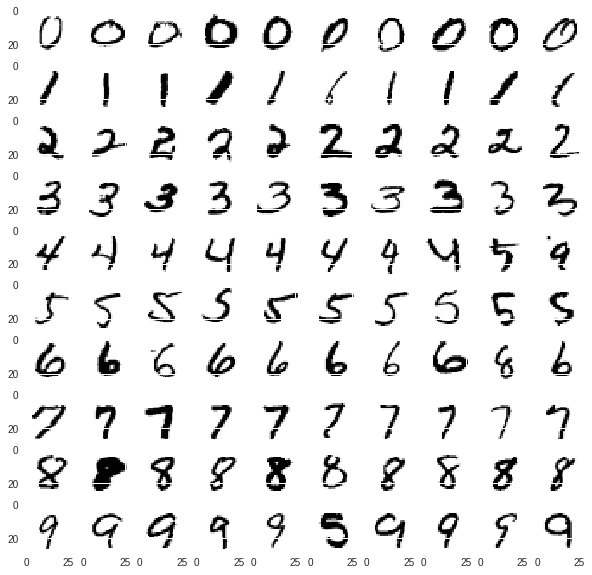

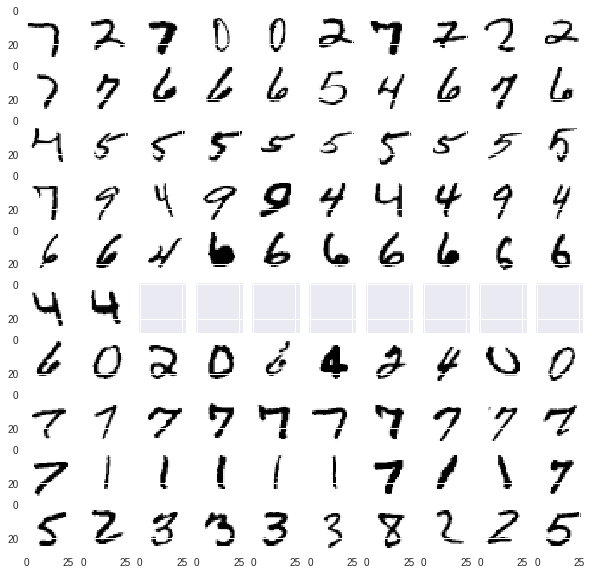

In [9]:
#Printing prediction of digits
ff_output1 = feedforward(test_x , output , 5)
ff_output2 = feedforward(test_x , output , 4)

print_digits(ff_output1, 10)
print_digits(ff_output2, 1024)

**Question 4**

From our results in 1.3 (ie from the last layer), we can see that we got perfect prediction for all the numbers from 0-9. There are only a few digits that are misclassified. This missclassification might be because the features learned by the model are in such a way that the digits that are misclassified might have the same features.

Talking about the second last layer, here from 1024 features, we randomly select 10 features. There is a possibility that not all the features are included in these 10 features. Due to the randomness we might also get features that are not really important to the model. This might be the reason why some of the subplots are empty and some of them are misclassfied. We should only take those features that are important, rather than selecting 10 random features.

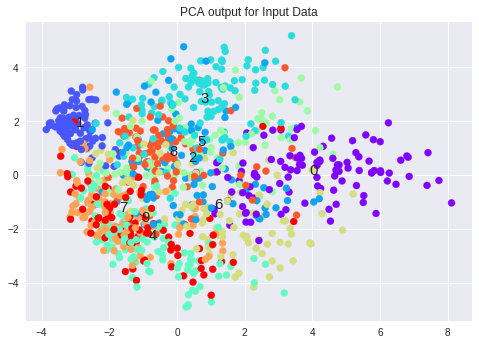

Explained variance for PCA at layer 0 is 0.17275888472795486


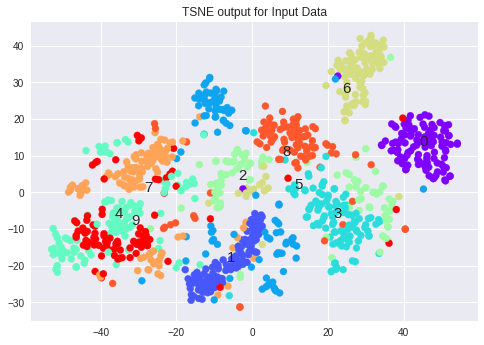

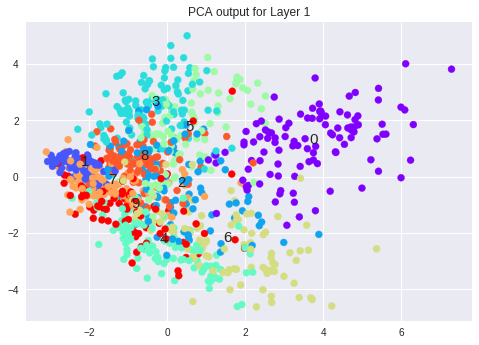

Explained variance for PCA at layer 1 is 0.18506059795618057


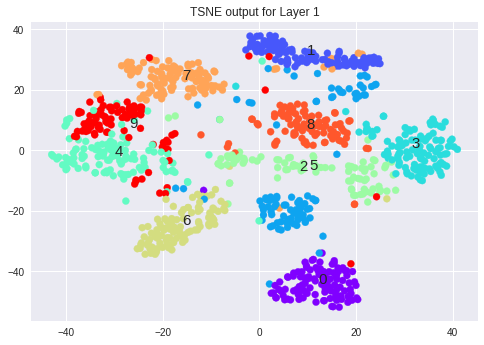

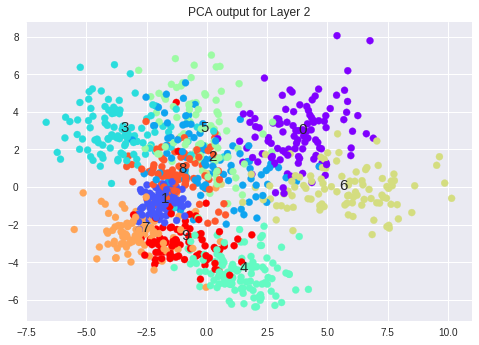

Explained variance for PCA at layer 2 is 0.29778286814689636


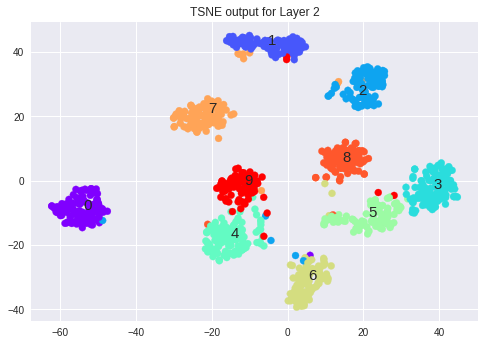

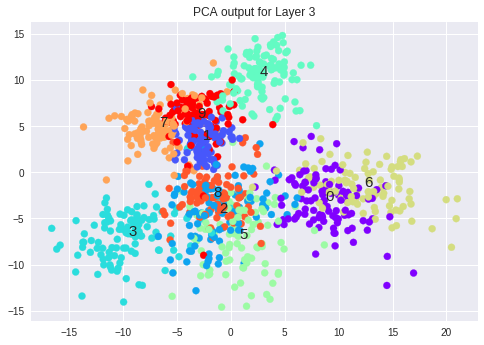

Explained variance for PCA at layer 3 is 0.41791900992393494


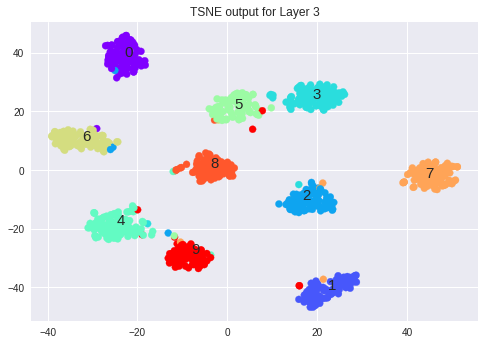

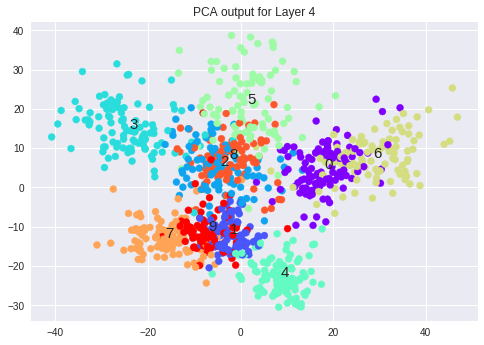

Explained variance for PCA at layer 4 is 0.4601430296897888


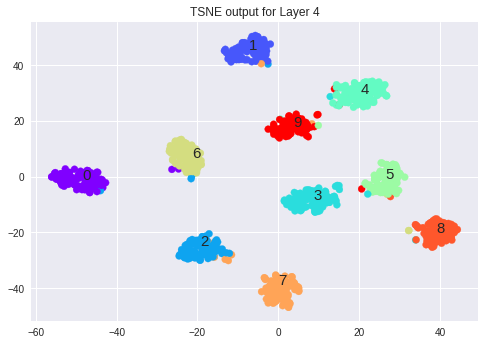

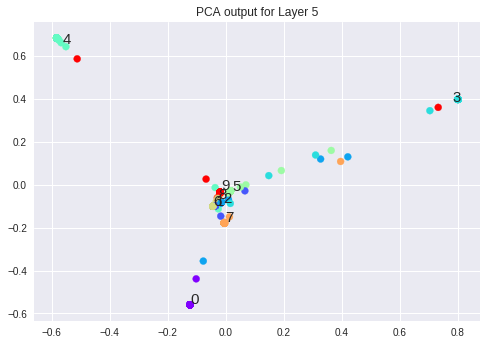

Explained variance for PCA at layer 5 is 0.24102336168289185


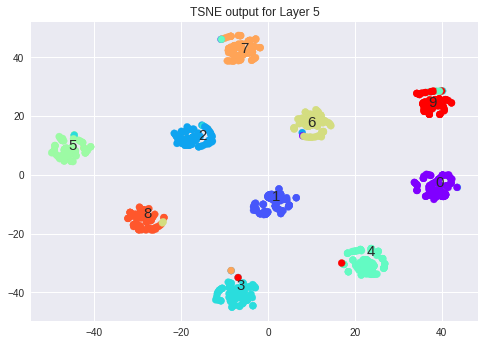

In [10]:
#Carrying out computations on 1000 test samples
test_x , test_y = mnist.test.next_batch(1000)
label_arg = np.argmax(test_y , axis = 1)

for i in range(0 , 6):
    #Computing the feed forward output 
    if i == 0:    
        ff_output = test_x
        title_pca = 'PCA output for ' + 'Input Data' 
        title_tsne = 'TSNE output for ' + 'Input Data'
    else:
        ff_output = feedforward(test_x , output , i)
        title_pca = 'PCA output for ' + 'Layer ' + str(i) 
        title_tsne = 'TSNE output for ' + 'Layer ' + str(i) 
    
    #Reducing the dimensions using PCA and TSNE
    output_pca , sum_exp_var = compute_PCA(ff_output.T , 2)
    output_tsne = compute_TSNE(ff_output , 2)
    
    #Calculating the means of output from PCA and TSNE
    grouped_means_pca = transform_data(output_pca.T , label_arg)
    grouped_means_tsne = transform_data(output_tsne.T , label_arg)    
  
    #Plotting results of PCA and TSNE
    print_plots(output_pca , label_arg , grouped_means_pca, title_pca)
    print('Explained variance for PCA at layer ' + str(i) + ' is ' + str(sum_exp_var))
    print_plots(output_tsne , label_arg , grouped_means_tsne, title_tsne)

**Question 6**

Talking about raw images(input data), there are 784 features which are reduced to 2 features by performing PCA and TSNE. There are some features in those 784 which are taken into consideration by the model while reduction, these features are not important for the model to classify the digits. Due to this reason, it is difficult to classify raw images.

**Question 8**

After the feedforward step on all the 5 layers of the model, we can see from the plots that as we go from first to the last layer, our classification result goes on improving which means that our model has learned features that are most important and used them to classify the results.

From our results it is clear to see that TSNE performs much better than PCA for MNIST digit recognition problem.
The reason for the same is that PCA does dimension reduction and tries to keep the features for which it has greater value of variance. While TSNE, groups the points based on thier visual similarity (ie distance similarity).
This is the reason why sometimes TSNE misclassifies few digits that have almost same features. 

If the explained variance ratio is less for PCA, then the features learned cannot be used. We can see that the explained variance ratio goes on increasing from layer to layer, but it is not enough the classify the digits into their respective classes.

FOr TSNE, lets take the last plot, here we can see that 1 '6' is misclassified as '8', it might be because of the curve that is present at the bottom of both the digits. TSNE puts more emphasis on intra clustering distance which is why all similar looking digits are clustered together.
